<a href="https://colab.research.google.com/github/asadali163/Time-Series-Experiments/blob/main/codebase/CNN_Airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O airline.csv https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-07-28 10:10:06--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline.csv’

airline.csv         100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-07-28 10:10:06 (23.9 MB/s) - ‘airline.csv’ saved [2036/2036]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPool1D, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_absolute_percentage_error

np.random.seed(42)
tf.random.set_seed(42)

In this notebook, we will do the following things
* 1 step forecast
* Multi step Forecast
* Multi step Multi output Forecast

### 1 step forecast

In [ ]:
df = pd.read_csv('airline.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
df['LogPassengers'] = np.log(df['Passengers'])

In [ ]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [ ]:
df.shape

(144, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Passengers         144 non-null    int64  
 1   LogPassengers      144 non-null    float64
 2   DiffLogPassengers  143 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 4.5 KB


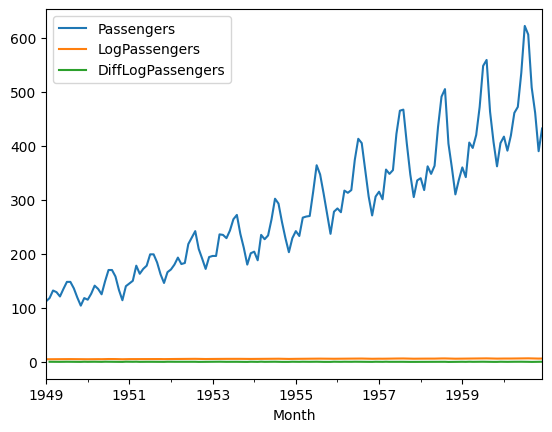

In [ ]:
df.plot();

In [ ]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [ ]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [ ]:
# Let's prepare data for 1 step forecast with previous 10 lags
series = df['DiffLogPassengers'].dropna().to_numpy()
T = 10
X, Y = [], []
for i in range(len(series) - T):
  x = series[i:i+T]
  X.append(x)
  y = series[i+T]
  Y.append(y)
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)

print('X shape: ', X.shape)
print('Y shape: ', Y.shape)

X shape:  (133, 10, 1)
Y shape:  (133,)


In [ ]:
X_train, X_test = X[:-N_test], X[-N_test:]
Y_train, Y_test = Y[:-N_test], Y[-N_test:]

In [ ]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(121, 10, 1) (12, 10, 1)
(121,) (12,)


In [ ]:
# CNN Architecture
i = Input(shape=(T, 1))
x = Conv1D(32, 3, activation='relu')(i)
x = MaxPool1D(2)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = GlobalMaxPool1D()(x)
output = Dense(1)(x)

model = Model(inputs=i, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 8, 32)             128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 32)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 65    

In [ ]:
# Let's compile the model
model.compile(optimizer=Adam(0.001), loss='mse')

In [ ]:
r = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=80, batch_size=32)

Epoch 1/80
4/4 [==============================] - 1s 73ms/step - loss: 0.0115 - val_loss: 0.0100
Epoch 2/80
4/4 [==============================] - 0s 12ms/step - loss: 0.0100 - val_loss: 0.0090
Epoch 3/80
4/4 [==============================] - 0s 13ms/step - loss: 0.0090 - val_loss: 0.0083
Epoch 4/80
4/4 [==============================] - 0s 12ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 5/80
4/4 [==============================] - 0s 14ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 6/80
4/4 [==============================] - 0s 16ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 7/80
4/4 [==============================] - 0s 12ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 8/80
4/4 [==============================] - 0s 13ms/step - loss: 0.0058 - val_loss: 0.0063
Epoch 9/80
4/4 [==============================] - 0s 12ms/step - loss: 0.0054 - val_loss: 0.0061
Epoch 10/80
4/4 [==============================] - 0s 12ms/step - loss: 0.0046 - val_loss: 0.0060
Epoch 11/80
4/4 [============

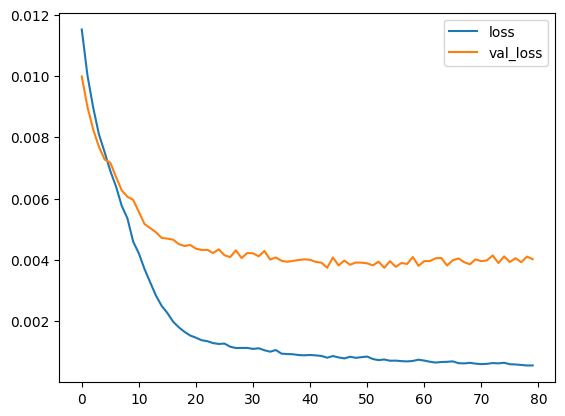

In [ ]:
# Let's plot loss graphs
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

In [ ]:
train_idx[:T+1] = False

In [ ]:
P_train = model.predict(X_train).reshape(-1)
P_test = model.predict(X_test).reshape(-1)

1/1 [==============================] - 0s 21ms/step


In [ ]:
df.loc[train_idx, 'Diff Train Prediction'] = P_train
df.loc[test_idx, 'Diff Test Prediction'] = P_test

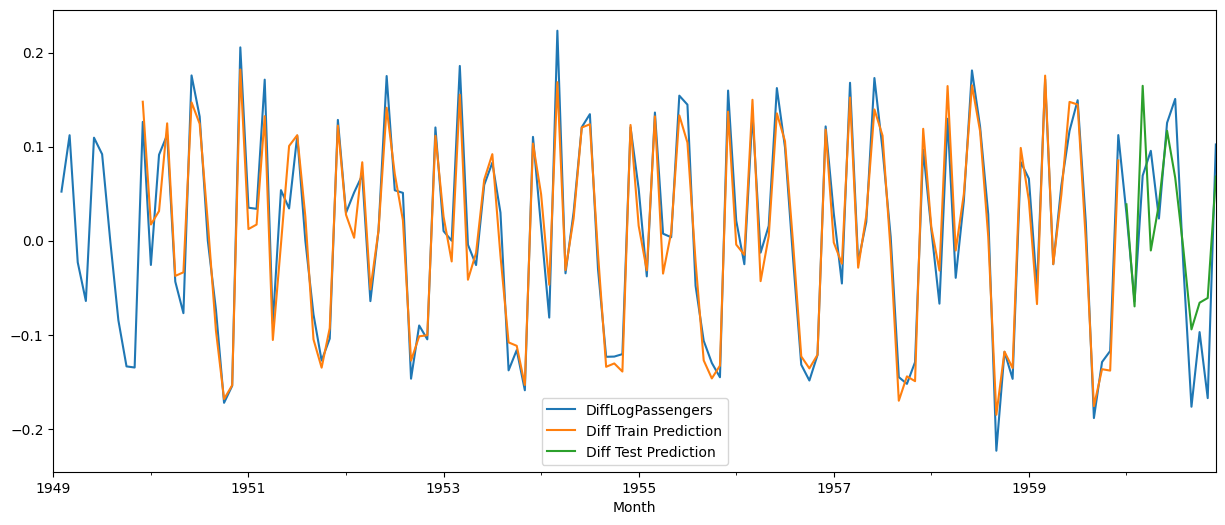

In [ ]:
# Let's plot
df[['DiffLogPassengers', 'Diff Train Prediction', 'Diff Test Prediction']].plot(figsize=(15,6));

In [ ]:
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [ ]:
last_train = train.iloc[-1]['LogPassengers']

In [ ]:
df.loc[train_idx, '1 Step Forecast Train'] = prev[train_idx] + P_train
df.loc[test_idx, '1 Step Forecast Test'] = prev[test_idx] + P_test

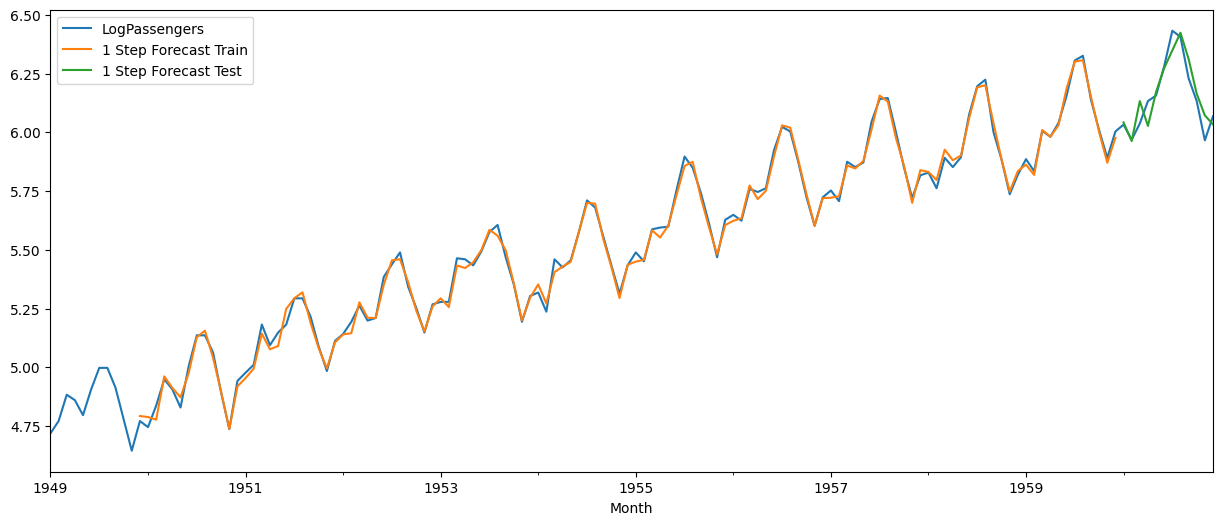

In [ ]:
# Let's plot 1 step forecast
df[['LogPassengers', '1 Step Forecast Train', '1 Step Forecast Test']].plot(figsize=(15,6));

As you can see it almost followed the trend, let's see the results of multi step forecast

In [ ]:
multistep_predictions = []

last_x = X_test[0]

while len(multistep_predictions) < N_test:
  p = model.predict(last_x.reshape(1, T, 1))[0]
  multistep_predictions.append(p)

  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 20ms/step


In [ ]:
# Let's save it in dataframe
df.loc[test_idx, 'Multi Step Forecast'] =  last_train + np.cumsum(multistep_predictions)

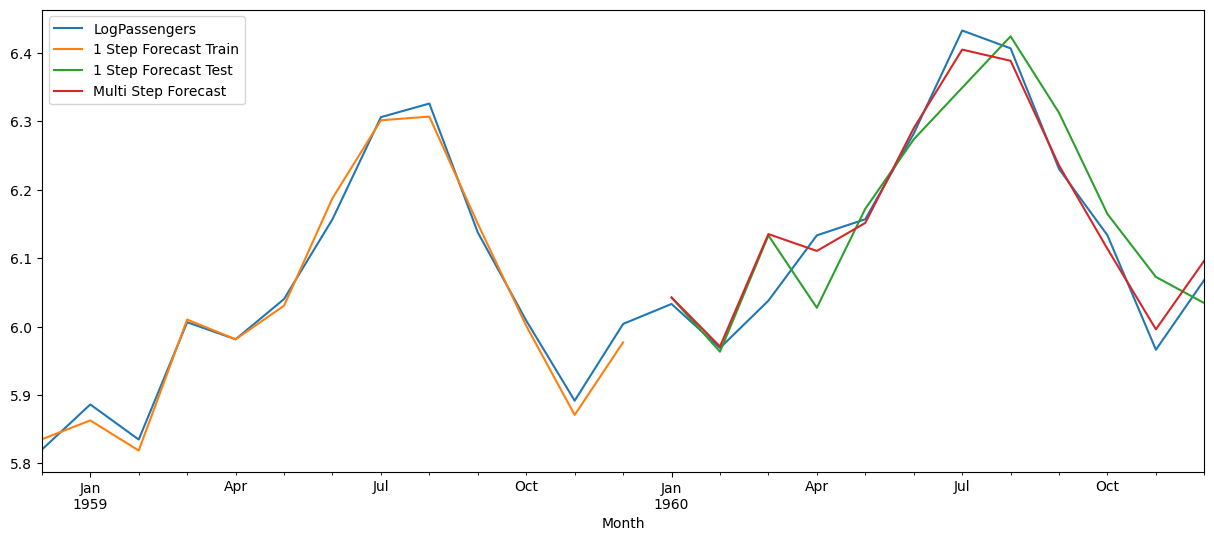

In [ ]:
# Let's plot all
df[['LogPassengers', '1 Step Forecast Train', '1 Step Forecast Test', 'Multi Step Forecast']][-25:].plot(figsize=(15,6));

As we can see that the multistep forecasat does the better job just by looking into the graph

### Now let's do the multistep multioutput forecast

In [ ]:
Tx = T
Ty = N_test
X, Y = [] , []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)

print('X shape: ', X.shape)
print('Y shape: ', Y.shape)


X shape:  (122, 10, 1)
Y shape:  (122, 12)


In [ ]:
X_train_m, X_test_m = X[:-1], X[-1:]
Y_train_m, Y_test_m = Y[:-1], Y[-1:]

print(X_train_m.shape, X_test_m.shape)
print(Y_train_m.shape, Y_test_m.shape)

(121, 10, 1) (1, 10, 1)
(121, 12) (1, 12)


In [ ]:
# Let's have CNN for this
i = Input(shape=(Tx, 1))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPool1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPool1D()(x)
output = Dense(Ty)(x)

model = Model(inputs=i, outputs=output)

In [ ]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 16)             64        
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 4, 16)             0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 32)             1568      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 12)                396 

In [ ]:
# Compile
model.compile(optimizer=Adam(0.001), loss='mse')

In [ ]:
# fit
r = model.fit(X_train_m, Y_train_m, validation_data=(X_test_m, Y_test_m), epochs=80, batch_size=32)

Epoch 1/80
4/4 [==============================] - 1s 67ms/step - loss: 0.0122 - val_loss: 0.0125
Epoch 2/80
4/4 [==============================] - 0s 12ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 3/80
4/4 [==============================] - 0s 11ms/step - loss: 0.0113 - val_loss: 0.0109
Epoch 4/80
4/4 [==============================] - 0s 14ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 5/80
4/4 [==============================] - 0s 15ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 6/80
4/4 [==============================] - 0s 16ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 7/80
4/4 [==============================] - 0s 15ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 8/80
4/4 [==============================] - 0s 13ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 9/80
4/4 [==============================] - 0s 14ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 10/80
4/4 [==============================] - 0s 12ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 11/80
4/4 [============

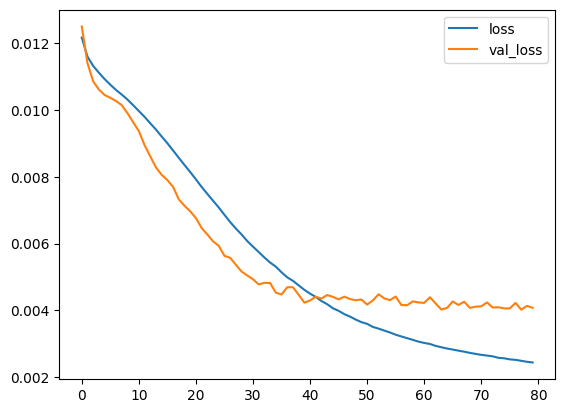

In [ ]:
# Let's plot the loss graph
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

In [ ]:
# Let's predict the test one
P_test_m = model.predict(X_test_m)

1/1 [==============================] - 0s 73ms/step


In [ ]:
P_test_m = P_test_m.flatten()
P_test_m.shape

(12,)

In [ ]:
# Let's save in dataframe
df.loc[test_idx, 'Multi Step Multi Output Forecast'] = last_train + np.cumsum(P_test_m)

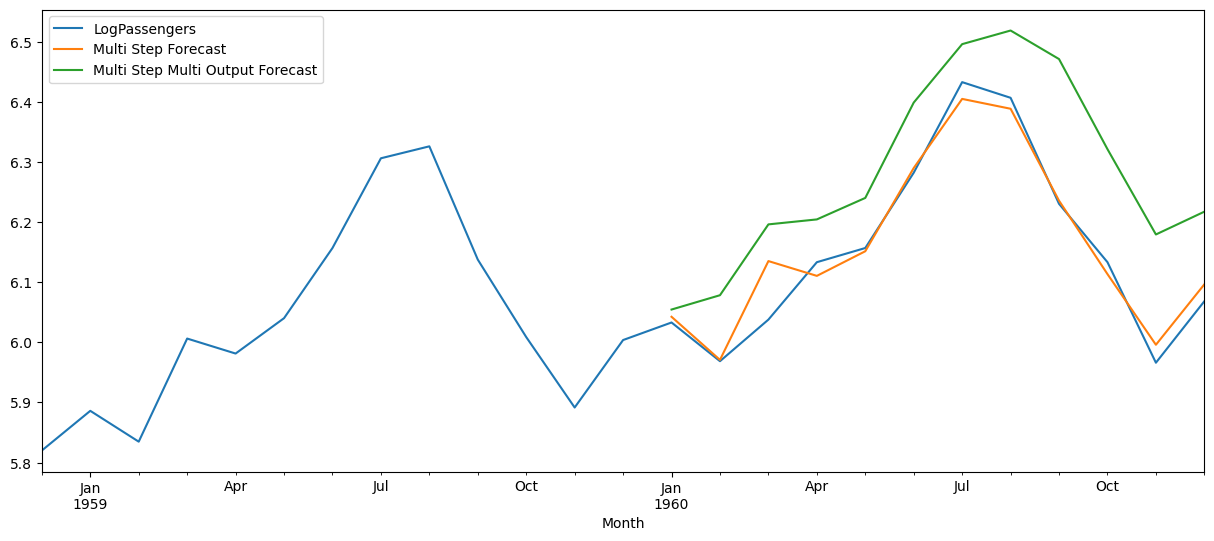

In [ ]:
# Let's plot
df[['LogPassengers', 'Multi Step Forecast', 'Multi Step Multi Output Forecast']][-25:].plot(figsize=(15,6));

As we can see that it is not good then the multi step forecast

In [ ]:
# Let's verify from mape
mape_multi_step = mean_absolute_percentage_error(df.loc[test_idx, 'LogPassengers'], df.loc[test_idx, 'Multi Step Forecast'])
mape_multi_output = mean_absolute_percentage_error(df.loc[test_idx, 'LogPassengers'], df.loc[test_idx, 'Multi Step Multi Output Forecast'])

print('Multi Step MAPE: ', mape_multi_step)
print('Multi Step Multi Output MAPE: ', mape_multi_output)


Multi Step MAPE:  0.003731450507197179
Multi Step Multi Output MAPE:  0.020736447416848644
